# Data Inspection

## Packages

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pycountry

## Load Data

In [5]:
country_df = pd.read_pickle("../../data/generated/country_df.pkl")
comes_from_df = pd.read_pickle("../../data/generated/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/generated/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/generated/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/generated/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/generated/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/generated/character_df.pkl")
actor_df = pd.read_pickle("../../data/generated/actor_df.pkl")
movie_df = pd.read_pickle("../../data/generated/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/generated/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/generated/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/generated/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")

## Country

### Create world map 

In [30]:
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE# create a column for code 

In [68]:
comes_from_display = comes_from_df.groupby("country_name").count().reset_index()
comes_from_display["CODE"] = alpha3code(comes_from_display["country_name"])
comes_from_display = comes_from_display.set_index("country_name")
comes_from_display.columns = ["movie_count","CODE"]
comes_from_display.head()

,movie_count,CODE
country_name,,
afghanistan,15,AFG
albania,28,ALB
algeria,43,DZA
argentina,1468,ARG
armenia,16,ARM


In [120]:
world_countries_df = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
world_countries_df.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world_wrong_code_ids = world_countries_df["CODE"] == "-99"
world_wrong_code = world_countries_df[world_wrong_code_ids]
world_countries_df.loc[world_wrong_code_ids,"CODE"] = alpha3code(world_wrong_code["name"])
world_merge = pd.merge(world_countries_df,comes_from_display,on='CODE')
world_merge = world_merge[~(world_merge["CODE"] == "None")]

In [121]:
world_merge

,pop_est,continent,name,CODE,gdp_md_est,geometry,movie_count
0,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",2534
1,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",7
2,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",124
3,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",1468
4,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",60
...,...,...,...,...,...,...,...
220,6653210,Africa,Libya,LBY,90890.0,"POLYGON ((25.00000 22.00000, 25.00000 20.00304...",4
221,105350020,Africa,Ethiopia,ETH,174700.0,"POLYGON ((47.78942 8.00300, 44.96360 5.00162, ...",10
222,3856181,Europe,Bosnia and Herz.,BIH,42530.0,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",35
223,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",57


<AxesSubplot:title={'center':'World Movie repartition'}>

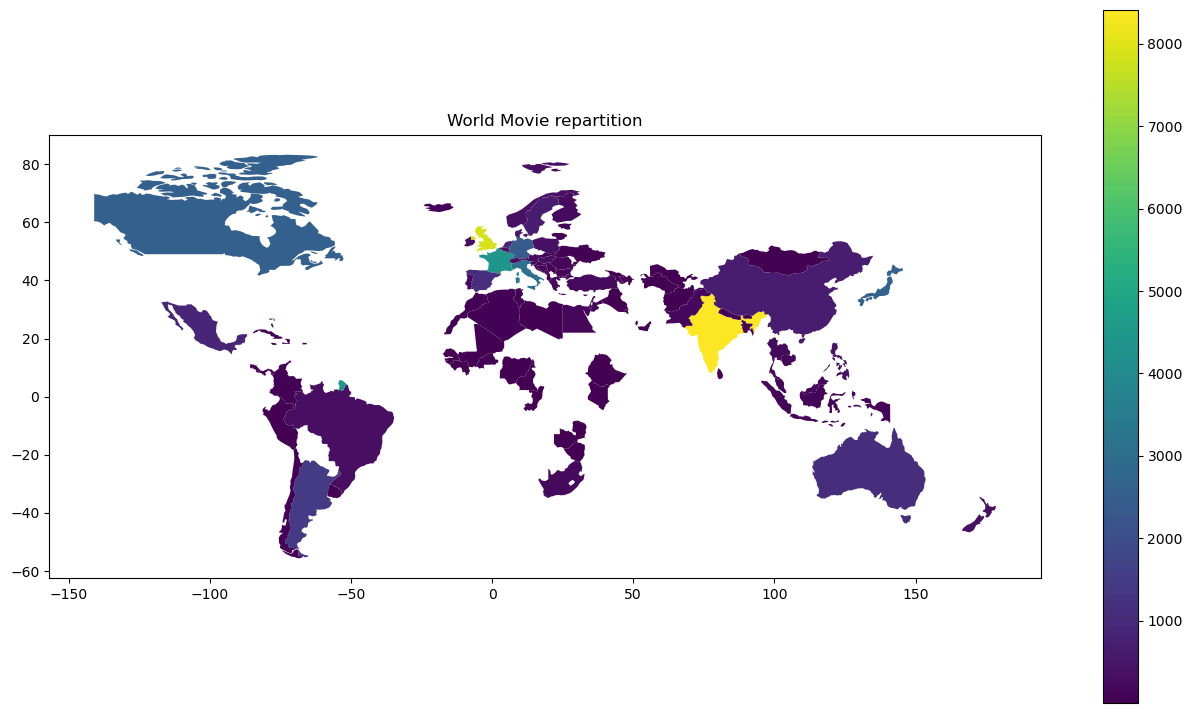

In [122]:
fig,ax = plt.subplots(1,figsize=(16,9))
ax.set_title("World Movie repartition")
world_merge.plot(column="movie_count",legend=True,ax=ax)

## Languages

In [123]:
help(world_merge.plot)

Help on GeoplotAccessor in module geopandas.plotting object:

class GeoplotAccessor(pandas.plotting._core.PlotAccessor)
 |  GeoplotAccessor(data)
 |  
 |  Plot a GeoDataFrame.
 |  
 |  Generate a plot of a GeoDataFrame with matplotlib.  If a
 |  column is specified, the plot coloring will be based on values
 |  in that column.
 |  
 |  Parameters
 |  ----------
 |  column : str, np.array, pd.Series (default None)
 |      The name of the dataframe column, np.array, or pd.Series to be plotted.
 |      If np.array or pd.Series are used then it must have same length as
 |      dataframe. Values are used to color the plot. Ignored if `color` is
 |      also set.
 |  kind: str
 |      The kind of plots to produce:
 |       - 'geo': Map (default)
 |       Pandas Kinds
 |       - 'line' : line plot
 |       - 'bar' : vertical bar plot
 |       - 'barh' : horizontal bar plot
 |       - 'hist' : histogram
 |       - 'box' : BoxPlot
 |       - 'kde' : Kernel Density Estimation plot
 |       - 'de

<AxesSubplot:ylabel='Count'>

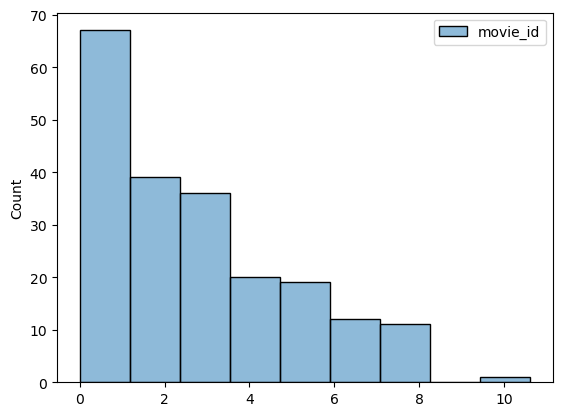

In [22]:
sns.histplot(spoken_languages_df.groupby("language_name").count().sort_values("movie_id",key=lambda l: -l).apply(np.log))